In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import matplotlib.pyplot as plt
import os
from pathlib import Path
import time
from data import download
import contextlib
from matplotlib.ticker import PercentFormatter
import geopandas as gpd
from shapely.geometry import Point
import folium

import io

with contextlib.redirect_stdout(io.StringIO()):
    data = download()

country_emissions = data['country_emissions']
emissions_sources = data['emissions_sources']
sources_ownership = data['sources_ownership']

#restricting to methane emissions
emissions_sources = emissions_sources.loc[ emissions_sources.gas == 'ch4' ]
emissions_sources = emissions_sources.drop(columns='gas')

#removing non-emitting sources
sum_emissions = emissions_sources.groupby('source_id').sum()[['emissions_quantity']]
non_zero_source = sum_emissions.loc[sum_emissions.emissions_quantity != 0].index.to_list()
emissions_sources = emissions_sources.loc[emissions_sources.source_id.isin(non_zero_source)  ] 

#removing the column "emissions_factor_units"
emissions_sources.rename(columns={'emissions_factor' : 'emissions_factor ' + emissions_sources.emissions_factor_units.unique()[0]}, inplace = True)
emissions_sources.drop(columns='emissions_factor_units', inplace = True)

#Defining a column to create a plot based on average emissions over a depth range
emissions_sources.loc[:, 'rounded Mine Depth'] = emissions_sources['Mine Depth'].apply(lambda x: 50*round(x/50, 0))
#emissions_sources.loc[:, 'rounded Mine Depth'] = emissions_sources['Mine Depth'].apply(lambda x: 10*round(x/10, 0))


In [3]:
#removing countries with no reported emissions for all gasses over all years
net_emissions = country_emissions.groupby(['country']).sum()[['emissions_quantity tonnes']].reset_index()
non_zero_country = net_emissions.loc[net_emissions['emissions_quantity tonnes'] != 0].country
# we can remove them from our analysis

emissions_gas_non_zero = country_emissions.pivot_table(index = ['country', 'year'], columns='gas', values = 'emissions_quantity tonnes')
emissions_gas_non_zero.reset_index(inplace=True)
emissions_gas_non_zero.columns.name = None
emissions_gas_non_zero.set_index(['country', 'year'], inplace = True)

emissions_gas_non_zero = emissions_gas_non_zero.loc[non_zero_country]
#removing co2 and n20 as no value is recorded for them
emissions_gas_non_zero = emissions_gas_non_zero[['ch4', 'co2e_20yr', 'co2e_100yr']]

methane_emissions = emissions_gas_non_zero[['ch4']]

In [4]:
methane_emissions_per_year = {}
list_years = country_emissions.year.unique()
for y in list_years:
    methane = methane_emissions.loc[(slice(None), y),:].droplevel('year')
    other = methane.sort_values('ch4')[:-6].sum()
    methane_emissions_per_year[y] = methane.sort_values('ch4', ascending =False).head(6)
    methane_emissions_per_year[y].loc['Rest of the world'] = other
    methane_emissions_per_year[y]['percentage'] = 100*(methane_emissions_per_year[y]['ch4']/(methane_emissions_per_year[y]['ch4'].sum()))



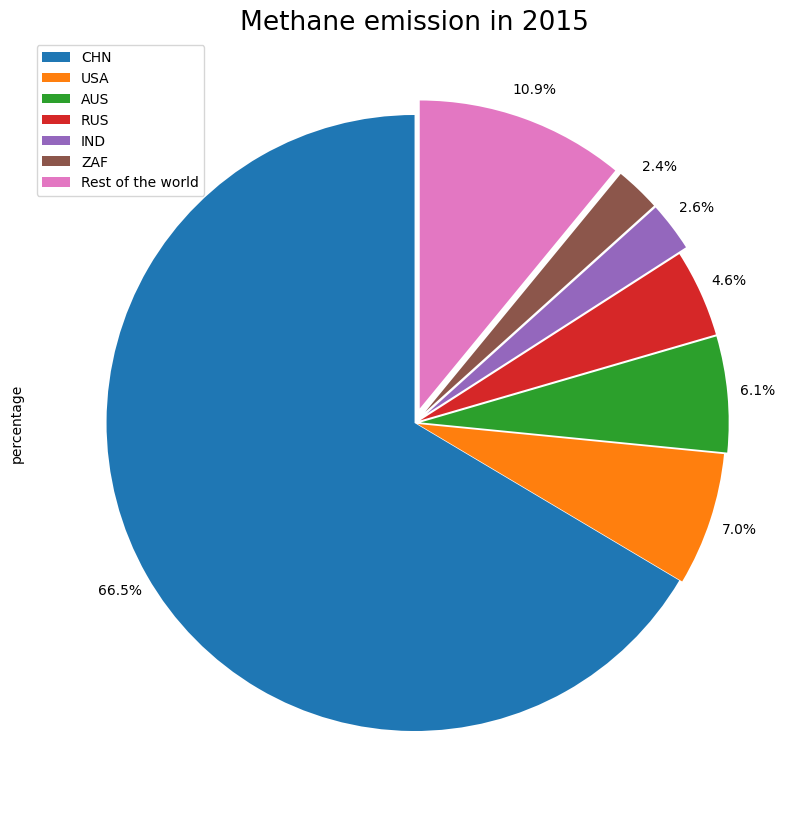

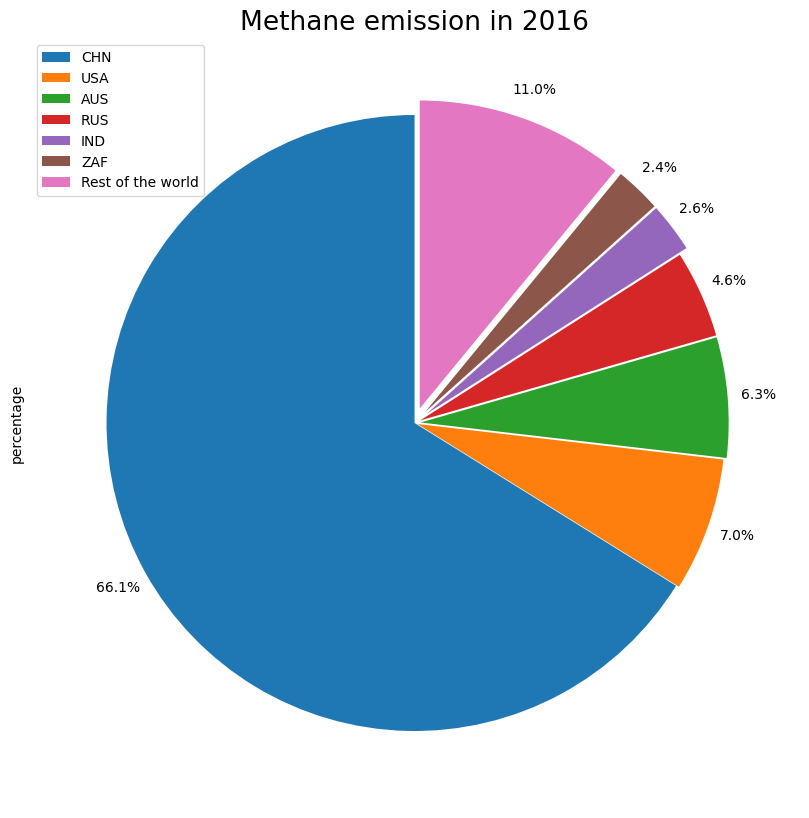

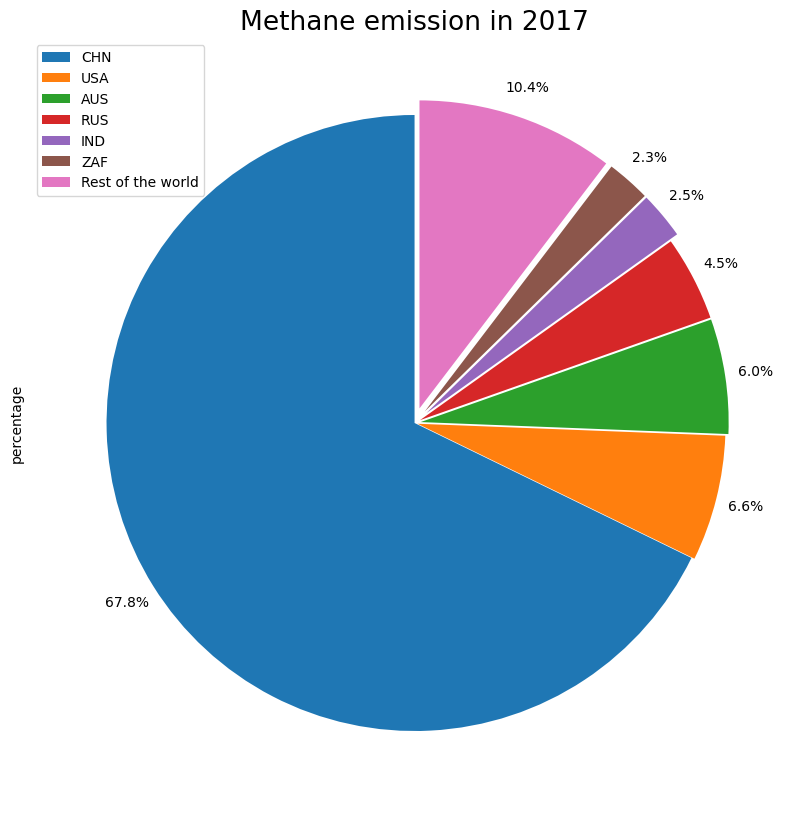

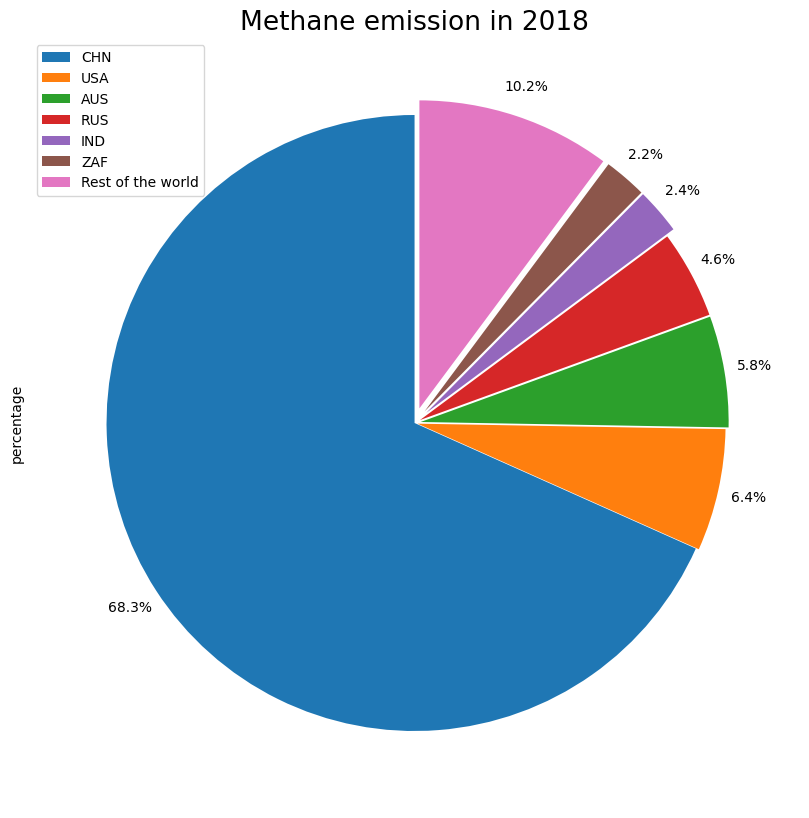

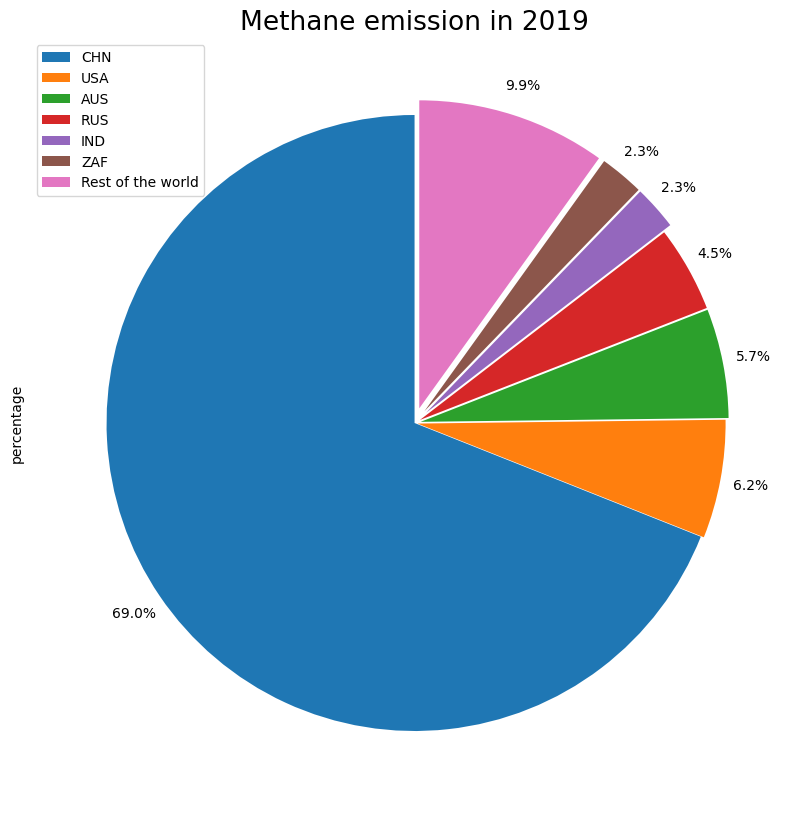

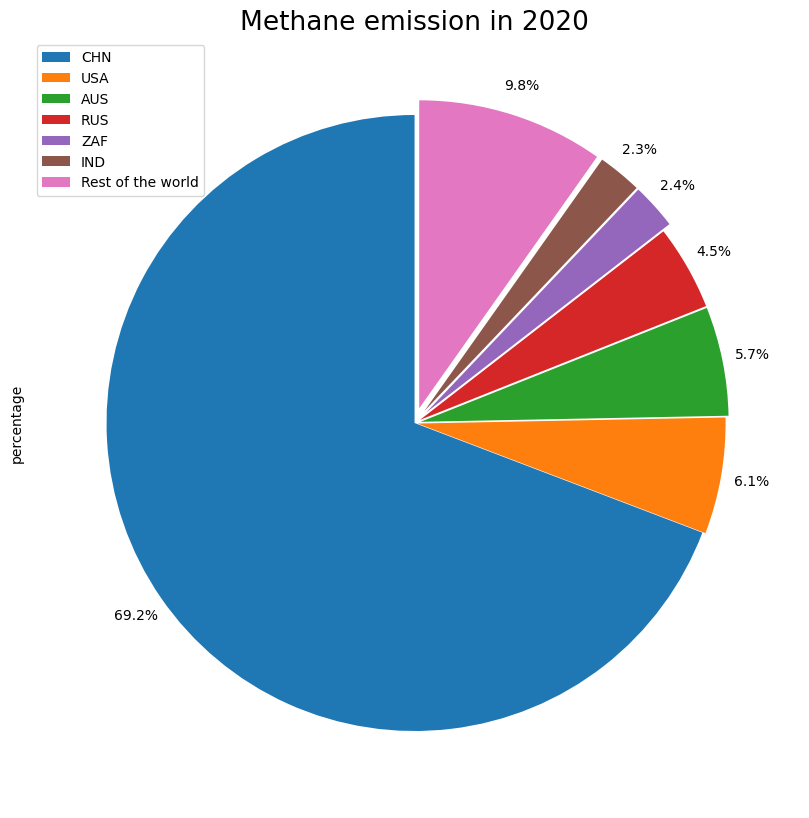

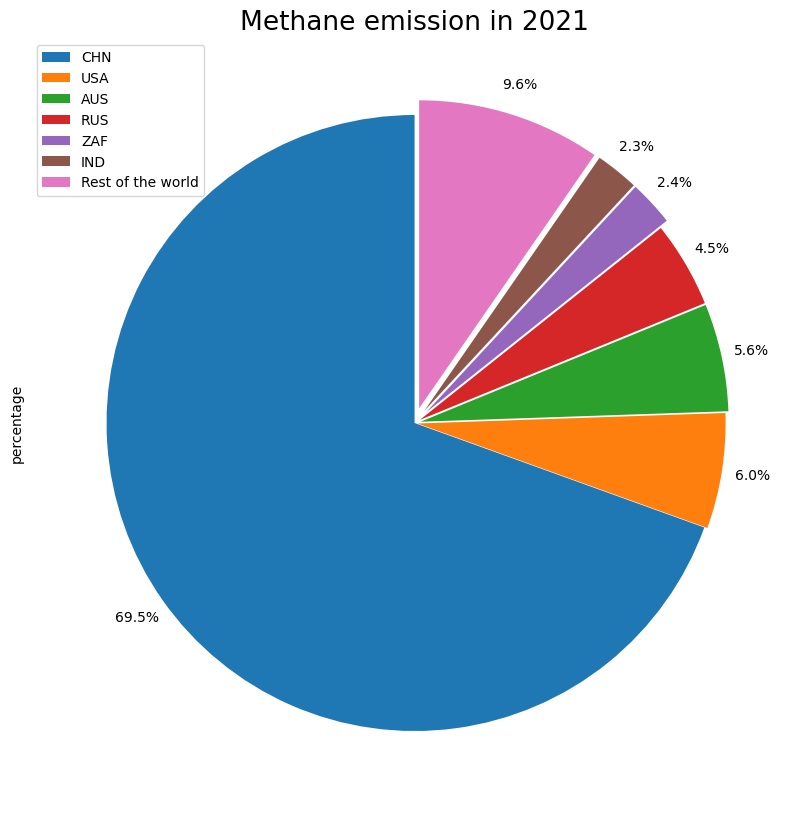

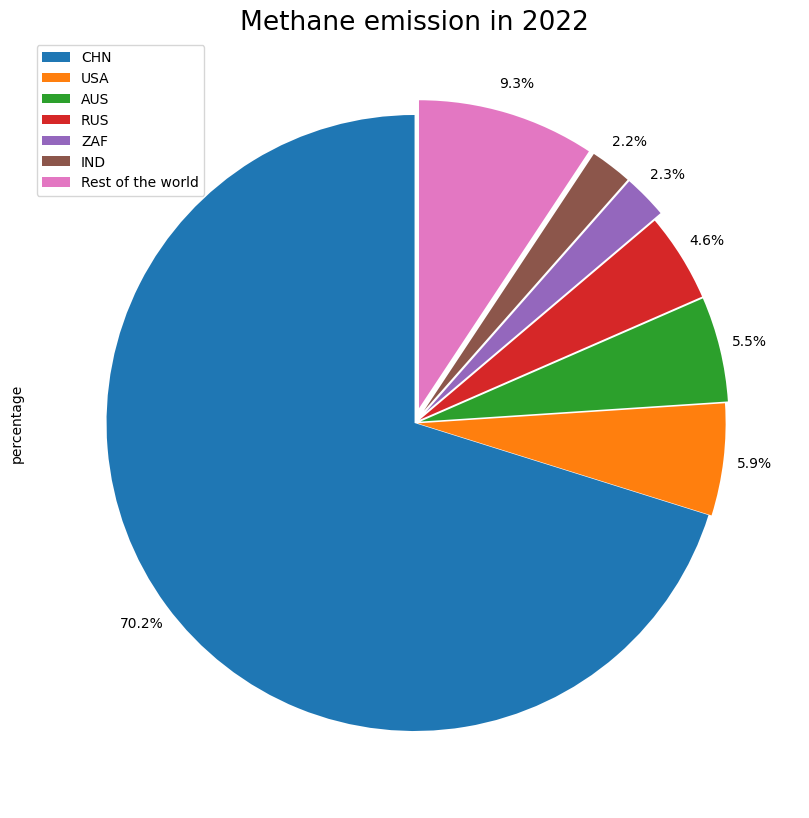

In [5]:
for y in list_years:
    explode_list = [0.0, 0.01, 0.02, 0.02, 0.05, 0.05, 0.05]
    pie  = methane_emissions_per_year[y].plot(kind = 'pie', y = 'percentage',
                                    figsize = (10,10),
                                    autopct = "%1.1f%%",
                                    startangle = 90,
                                    labels = None,
                                    pctdistance = 1.1,
                                    explode = explode_list                                   
                                    )
    plt.title('Methane emission in ' + str(y), fontsize = 19)
    #plt.axis('equal')
    plt.savefig( 'plots/' + str(y))
    plt.show()

In [6]:
top6_countries = methane_emissions_per_year[y].index.to_list()[:-1]
top6_countries_emissions = methane_emissions.loc[top6_countries]
top6_countries_emissions.loc[:, 'pct_change'] = top6_countries_emissions.groupby('country').pct_change()
pct_change = top6_countries_emissions[['pct_change']].dropna()
pct_change.reset_index(inplace = True)
pct_change.head()

,country,year,pct_change
0,CHN,2016,-0.000719
1,CHN,2017,0.090486
2,CHN,2018,0.040087
3,CHN,2019,0.039891
4,CHN,2020,0.021407


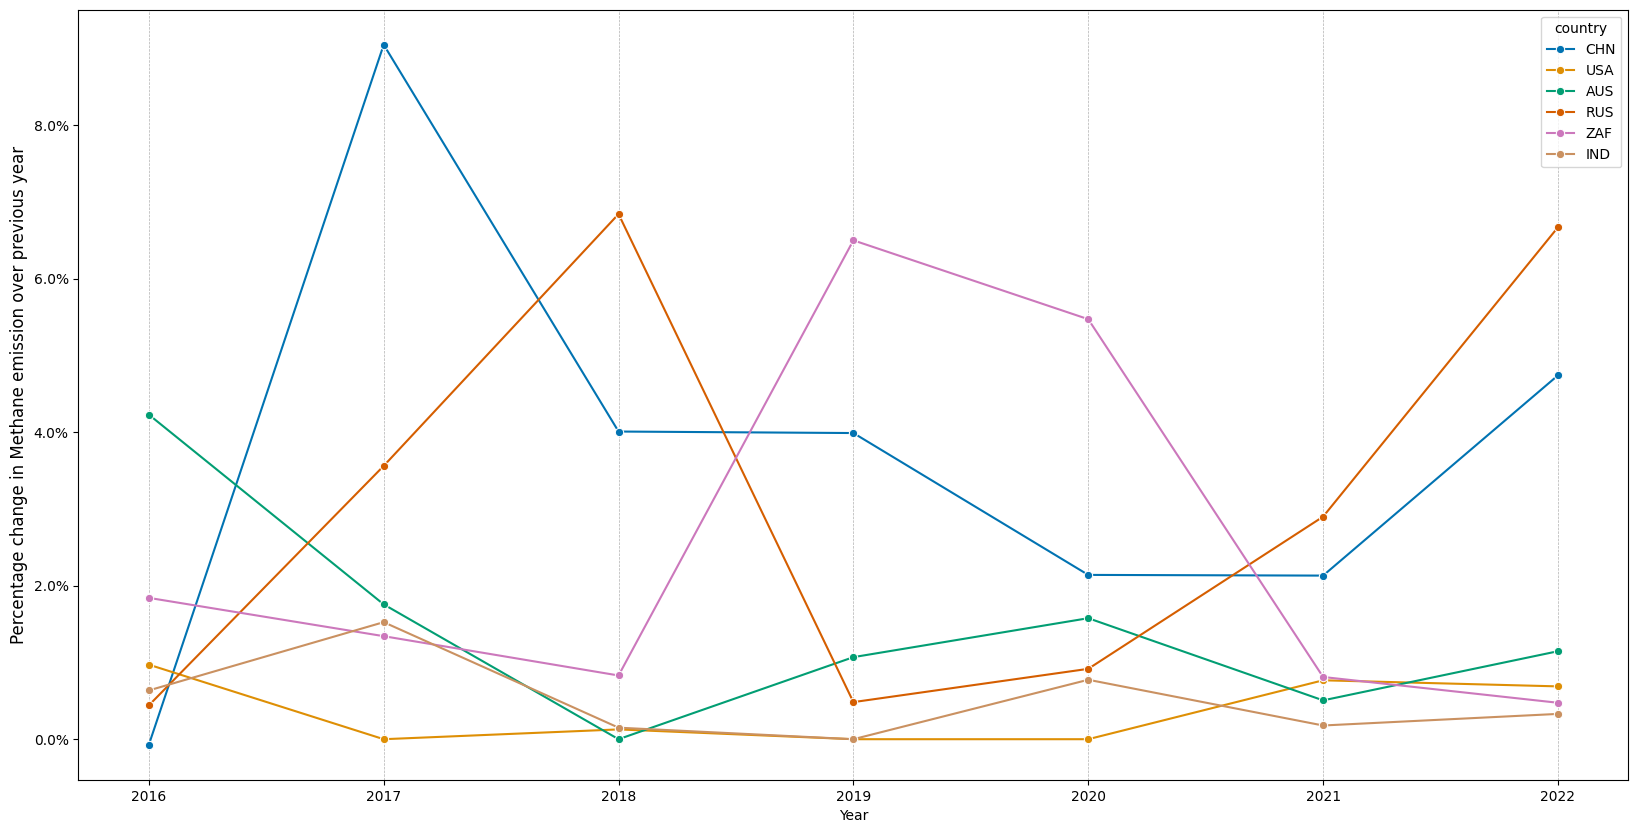

In [7]:
import seaborn as sns
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(20, 10))
ax = sns.lineplot(data = pct_change, x='year', y='pct_change', hue = 'country',marker='o', palette = 'colorblind')
plt.xlabel('Year')
plt.ylabel('Percentage change in Methane emission over previous year', fontsize = 12)
plt.xticks(pct_change.year.unique())
plt.grid(axis = 'x', ls = '--', lw = 0.5 )
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.savefig( 'plots/percent change methane emission' )
plt.show()

In [8]:
emissions_by_source_type = emissions_sources.groupby('source_type')[['emissions_factor T of CH4 per T of coal extracted']].mean()
print("number of sources for each type ", emissions_sources.groupby('source_type')['source_id'].count() )
emissions_by_source_type = 1000*emissions_by_source_type #convert to kilograms
emissions_by_source_type.rename(columns={'emissions_factor T of CH4 per T of coal extracted' : 'Kg of methane release per tonne of coal extracted'}, inplace = True)
emissions_by_source_type

number of sources for each type  source_type
Surface                  10543
Underground              12068
Underground & Surface      521
Name: source_id, dtype: int64


,Kg of methane release per tonne of coal extracted
source_type,
Surface,2.545799
Underground,14.893434
Underground & Surface,3.547378


In [9]:
emissions_by_coal_grade = 1000*emissions_sources.groupby('Coal Grade')[['emissions_factor T of CH4 per T of coal extracted']].mean()
emissions_by_coal_grade

,emissions_factor T of CH4 per T of coal extracted
Coal Grade,
Met,13.737851
Thermal,7.208009
Thermal & Met,13.636754
thermal,14.813303


In [10]:
emissions_by_coal_type = 1000*emissions_sources.groupby('Coal Type')[['emissions_factor T of CH4 per T of coal extracted']].mean()
emissions_by_coal_type

,emissions_factor T of CH4 per T of coal extracted
Coal Type,
Anthracite,22.951645
Bituminous,11.619337
Lignite,1.717916
Subbituminous,1.683686


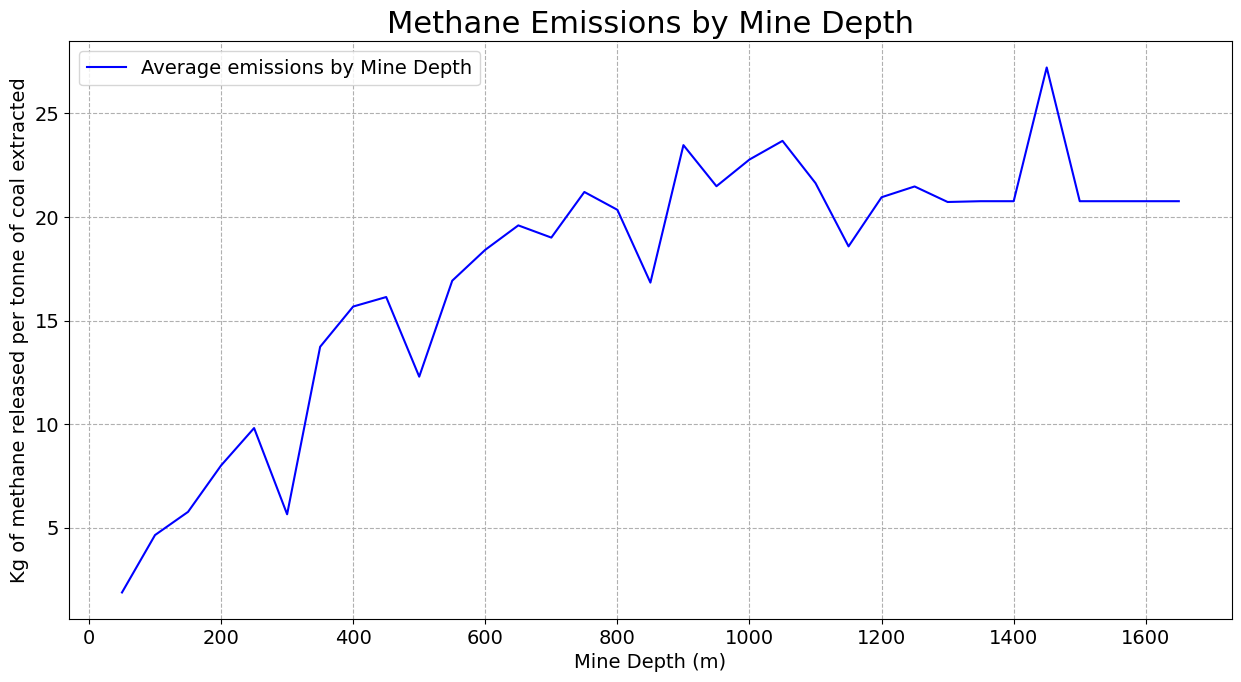

In [28]:
emissions_by_mine_depth = 1000*emissions_sources.groupby('rounded Mine Depth')[['emissions_factor T of CH4 per T of coal extracted']].mean()
no_of_mine = emissions_sources.groupby('rounded Mine Depth')['source_id'].count().sort_values()
emissions_by_mine_depth.reset_index(inplace=True)

no_of_mine = emissions_sources.groupby('rounded Mine Depth')['source_id'].count().sort_values()
emissions_by_mine_depth = emissions_by_mine_depth.loc[emissions_by_mine_depth['rounded Mine Depth'].isin(no_of_mine[no_of_mine>15].index.to_list()) ]

plt.figure(figsize=(15, 7.5))
ax = plt.gca()  
#emissions_by_mine_depth.set_index('rounded Mine Depth').plot( ax = ax, label='Emissions by Mine Depth', legend = True)
ax.plot(emissions_by_mine_depth['rounded Mine Depth'], 
        emissions_by_mine_depth['emissions_factor T of CH4 per T of coal extracted'], 
        label='Average emissions by Mine Depth', color='blue')

plt.grid(ls = '--')
#ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.ylabel('Kg of methane released per tonne of coal extracted', fontsize = 14)
plt.xlabel('Mine Depth (m)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Methane Emissions by Mine Depth', fontsize = 22)

plt.legend(fontsize = 14)
plt.savefig( 'plots/methane release by depth' )
plt.show()

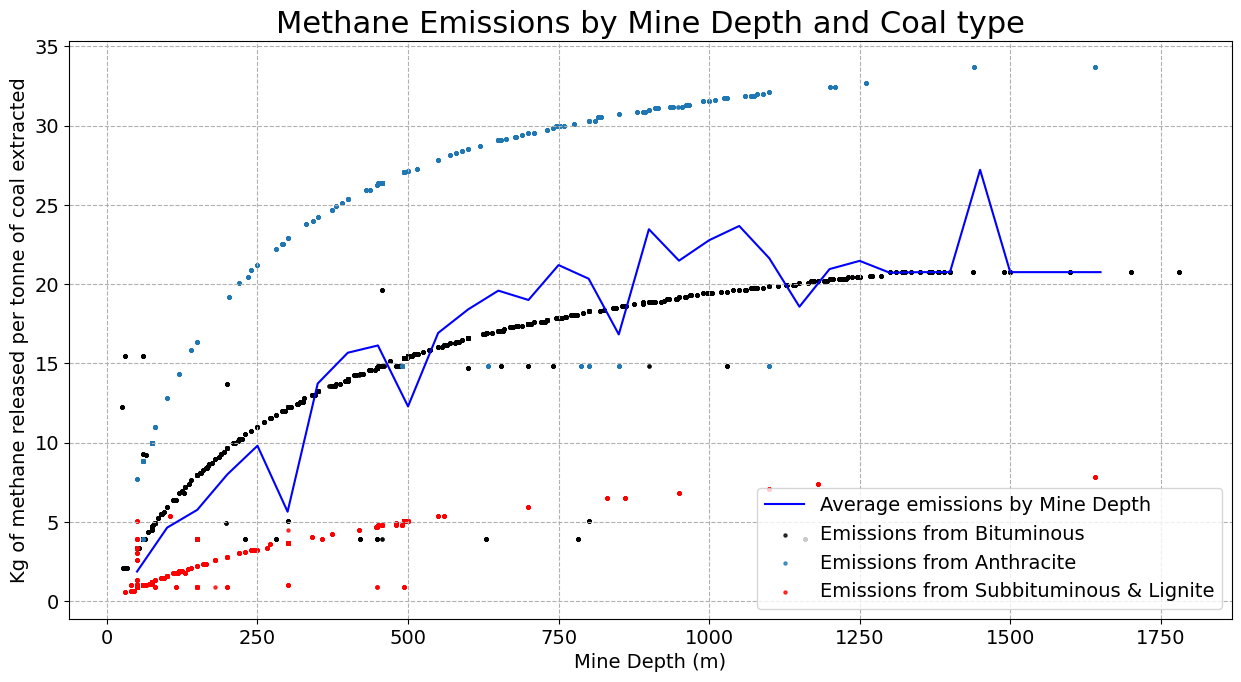

In [12]:
emissions_by_mine_depth = 1000*emissions_sources.groupby('rounded Mine Depth')[['emissions_factor T of CH4 per T of coal extracted']].mean()
no_of_mine = emissions_sources.groupby('rounded Mine Depth')['source_id'].count().sort_values()
emissions_by_mine_depth.reset_index(inplace=True)

Coal_type_B = ["Bituminous" ]
Coal_type_A = ["Anthracite" ]

Coal_type_SL = ["Subbituminous", "Lignite" ]

em_by_type_SL = emissions_sources.loc[emissions_sources['Coal Type'].isin(Coal_type_SL)]
em_by_type_SL.loc[:, 'emissions_factor T of CH4 per T of coal extracted'] = 1000*em_by_type_SL['emissions_factor T of CH4 per T of coal extracted']

em_by_type_B = emissions_sources.loc[emissions_sources['Coal Type'].isin(Coal_type_B)]
em_by_type_B.loc[:, 'emissions_factor T of CH4 per T of coal extracted'] = 1000*em_by_type_B['emissions_factor T of CH4 per T of coal extracted']

em_by_type_A = emissions_sources.loc[emissions_sources['Coal Type'].isin(Coal_type_A)]
em_by_type_A.loc[:, 'emissions_factor T of CH4 per T of coal extracted'] = 1000*em_by_type_A['emissions_factor T of CH4 per T of coal extracted']

no_of_mine = emissions_sources.groupby('rounded Mine Depth')['source_id'].count().sort_values()
emissions_by_mine_depth = emissions_by_mine_depth.loc[emissions_by_mine_depth['rounded Mine Depth'].isin(no_of_mine[no_of_mine>15].index.to_list()) ]

plt.figure(figsize=(15, 7.5))
ax = plt.gca()  
#emissions_by_mine_depth.set_index('rounded Mine Depth').plot( ax = ax, label='Emissions by Mine Depth', legend = True)
ax.plot(emissions_by_mine_depth['rounded Mine Depth'], 
        emissions_by_mine_depth['emissions_factor T of CH4 per T of coal extracted'], 
        label='Average emissions by Mine Depth', color='blue')

#em_by_type_BA.plot(kind='scatter', x ='Mine Depth', y = 'emissions_factor T of CH4 per T of coal extracted', ax = ax, label = 'Emissions from Bituminous & Anthracite', s = 5, alpha = 0.75)
em_by_type_B.plot(kind='scatter', x ='Mine Depth', y = 'emissions_factor T of CH4 per T of coal extracted', ax = ax, color = 'black', label = 'Emissions from Bituminous', s = 5, alpha = 0.75)
em_by_type_A.plot(kind='scatter', x ='Mine Depth', y = 'emissions_factor T of CH4 per T of coal extracted', ax = ax, label = 'Emissions from Anthracite', s = 5, alpha = 0.75)
em_by_type_SL.plot(kind='scatter', x ='Mine Depth', y = 'emissions_factor T of CH4 per T of coal extracted', ax = ax, color = 'red', label = 'Emissions from Subbituminous & Lignite', s= 5, alpha = 0.75)
plt.grid(ls = '--')
#ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.ylabel('Kg of methane released per tonne of coal extracted', fontsize = 14)
plt.xlabel('Mine Depth (m)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Methane Emissions by Mine Depth and Coal type', fontsize = 22)

plt.legend(fontsize = 14)
plt.savefig( 'plots/methane release by depth and coal type' )
plt.show()

In [13]:
sources_ownership_reset = sources_ownership.set_index('source_id')
emissions_sources_reset = emissions_sources.set_index('source_id')

emissions_sources_reset.head(2)


,source_name,source_type,country,year,lat,lon,emissions_quantity,activity T of coal,emissions_factor T of CH4 per T of coal extracted,capacity T per year,capacity_factor,Coal Type,Coal Grade,Total Reserves (Proven and Probable),"Total Resource (Inferred, Indicated, Measured)","Primary Consumer, Destination","Coal Plant, Steel Plant, Terminal",Mine Depth,rounded Mine Depth
source_id,,,,,,,,,,,,,,,,,,,
3162256,Dahna Toor Coal Mine,Underground,AFG,2015,35.704992,67.312196,4292.491328,850000.0,0.00505,1.186753e+06,0.71624,Subbituminous,Thermal,NaN,NaN,NaN,NaN,494.0,500.0
3162256,Dahna Toor Coal Mine,Underground,AFG,2016,35.704992,67.312196,4292.491328,850000.0,0.00505,1.186753e+06,0.71624,Subbituminous,Thermal,NaN,NaN,NaN,NaN,494.0,500.0


In [14]:
sources_merged =  emissions_sources_reset.join(sources_ownership_reset[['company_name', 'ultimate_parent_name', 'ultimate_parent_id', 'company_id', 
                                                                        'percent_interest_parent', 'percent_interest_company', 'percent_company_datasource', 
                                                                        'percent_parent_datasource', 'ultimate_parent_revenue_annual (mil)']], how='left')

In [15]:
sources = sources_merged[['source_name', 'source_type', 'country', 'company_name', 'year', 'ultimate_parent_name', 'ultimate_parent_id', 'company_id',
                'emissions_quantity', 'activity T of coal', 'emissions_factor T of CH4 per T of coal extracted', 
                'Coal Type', 'Coal Grade', 'percent_interest_parent', 'percent_interest_company','Mine Depth' ]]
sources.reset_index(inplace=True)

In [16]:
sources.groupby('ultimate_parent_name')[['source_id']].nunique().sort_values('source_id', ascending=False).head(5)

,source_id
ultimate_parent_name,
other,509
Coal India,283
Shanxi Provincial Department of Finance,204
Shanxi State-Owned Capital Investment and Operation,173
China Cinda Asset Management,139


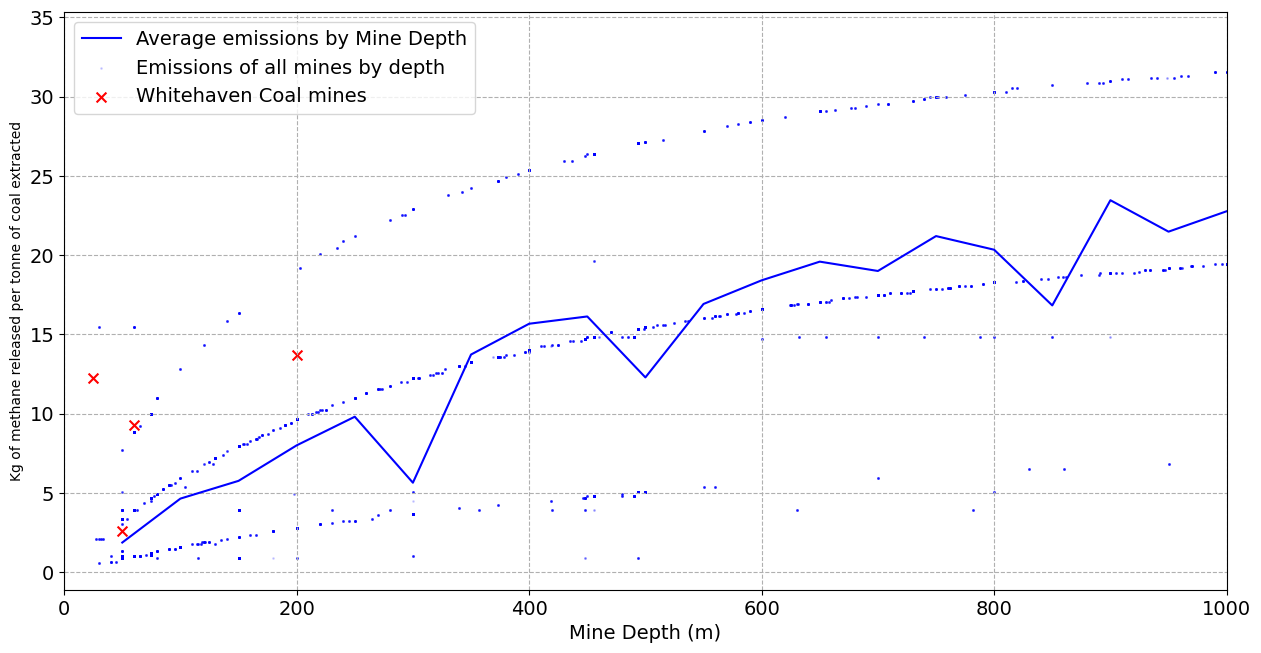

In [17]:
Company_of_interest = "Whitehaven Coal"
Whitehaven_Coal_mines = sources.groupby('ultimate_parent_name')['source_id'].unique()[Company_of_interest]
Whitehaven_Coal = emissions_sources_reset.loc[Whitehaven_Coal_mines]
Whitehaven_Coal = Whitehaven_Coal.groupby('source_id')[['emissions_quantity', 'activity T of coal', 'Mine Depth', 'rounded Mine Depth']].mean()
Whitehaven_Coal.loc[:, 'emissions_factor T of CH4 per T of coal extracted'] = 1000*Whitehaven_Coal['emissions_quantity']/Whitehaven_Coal['activity T of coal']
#coal_india_emissions_dept_em = coal_india_emissions.reset_index()[['rounded Mine Depth', 'emissions_factor T of CH4 per T of coal extracted']]
Whitehaven_Coal_em = Whitehaven_Coal.reset_index()[['Mine Depth', 'emissions_factor T of CH4 per T of coal extracted']]
em = emissions_sources.copy()
em.loc[:, 'emissions_factor T of CH4 per T of coal extracted'] = 1000*em['emissions_factor T of CH4 per T of coal extracted']
#Shanxi_Provincial_emissions_em = temp_em

# Line plot
plt.figure(figsize=(15, 7.5))
ax = plt.gca()  
ax.plot(emissions_by_mine_depth['rounded Mine Depth'], 
        emissions_by_mine_depth['emissions_factor T of CH4 per T of coal extracted'], 
        label='Average emissions by Mine Depth', color='blue')
em.plot(kind='scatter', x='Mine Depth', y='emissions_factor T of CH4 per T of coal extracted', ax=ax, color='blue', label= "Emissions of all mines by depth", s = 1, alpha = 0.15)
Whitehaven_Coal_em.plot(kind='scatter', x='Mine Depth', y='emissions_factor T of CH4 per T of coal extracted', ax=ax, color='red', label= Company_of_interest+" mines", s = 50, marker = 'x')

plt.grid(ls='--')
plt.ylabel('Kg of methane released per tonne of coal extracted')
plt.xlabel('Mine Depth (m)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(left = 0, right = 1000)
#plt.title('Methane Emissions for ' + Company_of_interest, fontsize = 22)
plt.legend(fontsize = 14)

# Scatter plot
# Save the figure
plt.savefig('plots/methane_release_by_depth_Whitehaven Coal')
plt.show()